#**Imports**

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import os

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image

In [ ]:
from PIL import Image
from torchvision import transforms

Use CUDA if available, else fall back to CPU.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Dataset**

Specifying the dimensions of sub-images on which the model is to be trained.


In [ ]:
img_rows, img_cols = 33, 33
out_rows, out_cols = 33, 33

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Assigning the training file (.h5) to a variable called file.
The file has sub-images of T91 images.

In [ ]:
sub_img_file = h5py.File('/content/drive/MyDrive/MySRC/input/train_mscale.h5')

Extracting labels and targets from file and storing into separate variables.

In [ ]:
input = sub_img_file['data'][:]
target = sub_img_file['label'][:]
sub_img_file.close()

input = input.astype('float32')
target = target.astype('float32')

<class 'numpy.ndarray'>


Splitting the dataset into training and validating datasets.

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(input, target, test_size = 0.25)
print('Training Samples: ', x_train.shape)
print('Validation Samples: ', x_val.shape)

Training Samples:  (16368, 1, 33, 33)
Validation Samples:  (5456, 1, 33, 33)


## Custom Dataset Class

In [ ]:
class SRCNNDataset(Dataset):
  def __init__(self, image_data, labels):
    self.image_data = image_data
    self.labels = labels

  def __len__(self):
    return len(self.image_data)

  def __getitem__(self, index):
    image = self.image_data[index]
    label = self.labels[index]
    return torch.tensor(image, dtype = torch.float), torch.tensor(label, dtype = torch.float)

# **Model Architecture**

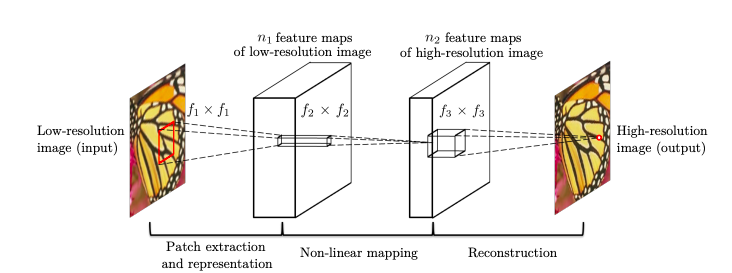

In [ ]:
class SRCNN(nn.Module):
  def __init__(self):
    super(SRCNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size = 9, padding = 2, padding_mode = 'replicate')
    self.conv2 = nn.Conv2d(64, 32, kernel_size = 1, padding = 2, padding_mode = 'replicate')
    self.conv3 = nn.Conv2d(32, 1, kernel_size = 5, padding = 2, padding_mode = 'replicate')

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.conv3(x)

    return x

# **Training**

Specifying training data and validation data.

In [ ]:
train_data = SRCNNDataset(x_train, y_train)
val_data = SRCNNDataset(x_val, y_val)

The model is defined and loaded onto the current device.

In [ ]:
model = SRCNN().to(device)

Specifying the learning parameters.

In [ ]:
batch_size = 64
epochs = 400
lr = 0.001

Loading the training data and validation data into train_loader and val_loader, respectively.

In [ ]:
train_loader = DataLoader(train_data, batch_size = batch_size)
val_loader = DataLoader(val_data, batch_size = batch_size)

Specifying the optimizer and the loss function.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()

psnr function is to calculate peak signal to noise ratio of target image to output image.

In [ ]:
def psnr(label, outputs, max_val = 1.0):
  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()
  img_diff = outputs - label
  rmse = math.sqrt(np.mean((img_diff) ** 2))
  return 100 if rmse == 0 else 20 * math.log10(max_val / rmse)

This function is to train the model on the given dataset.

In [ ]:
def train(model, dataloader):
  model.train()
  running_loss = 0.0
  running_psnr = 0.0
  for _, data in tqdm(enumerate(dataloader)):
    image_data = data[0].to(device)
    label = data[1].to(device)

    optimizer.zero_grad()
    outputs = model(image_data)
    loss = criterion(outputs, label)

    # Backpropogation
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    batch_psnr = psnr(label, outputs)
    running_psnr += batch_psnr

  final_loss = running_loss / len(dataloader.dataset)
  final_psnr = running_psnr / int(len(train_data) / dataloader.batch_size)

  return final_loss, final_psnr

validate function to validate the model, calculate loss and psnr, which is used for efficient training of the model.

In [ ]:
def validate(model, dataloader, epoch):
  model.eval()
  running_loss = 0.0
  running_psnr = 0.0
  with torch.no_grad():
    for bi, data in tqdm(enumerate(dataloader), total = int(len(val_data) / dataloader.batch_size)):
      image_data = data[0].to(device)
      label = data[1].to(device)

      outputs = model(image_data)
      loss = criterion(outputs, label)

      running_loss += loss.item()

      batch_psnr = psnr(label, outputs)
      running_psnr += batch_psnr

    outputs = outputs.cpu()
    save_image(outputs, f"drive/MyDrive/MySRC/outputs/val_sr{epoch}.png")

  final_loss = running_loss / len(dataloader.dataset)
  final_psnr = running_psnr / int(len(val_data) / dataloader.batch_size)

  return final_loss, final_psnr

fit function calls train function and validate function for training of the model.

In [ ]:
def fit(model, epochs, train_loader, val_loader):
  train_loss, val_loss = [], []
  train_psnr, val_psnr = [], []
  start = time.time()
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
  return train_loss, train_psnr, val_loss, val_psnr

  torch.save(model.state_dict(), "drive/MyDrive/MySRC/outputs/train_res_400_epochs.pth")
  end = time.time()
  print(f"Finished training in: {((end-start)/60):.3f} minutes")

In [ ]:
train_loss, train_psnr, val_loss, val_psnr = fit(model, epochs, train_loader, val_loader)

Loading the weights and biases learnt by the model.

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/MySRC/outputs/train_res_more_epochs.pth", map_location = device))

<All keys matched successfully>

# **Testing**

A function to resize the test image to a standard size of (96, 96).

In [ ]:
def resize(img, new_size = (96, 96)):
  img = img.resize(new_size)
  return img

**Function to test the image**<br>


1.   Preprocesses the image- convertes to YCbCr, upscales to the desired size using Bicubic Interpolation.
2.   Extracts the Y channel.
3.   Performs super resolution on the Y channel.
4.   Merges the output Y channel with Cb and Cr channels.
5.   Converts back to RGB.



In [ ]:
def test_img(img_path):
  img = Image.open(img_path).convert('YCbCr')
  original_img_size = img.size
  img = resize(img)
  img = img.resize((int(img.width * 3), int(img.height * 3)), Image.BICUBIC)

  y, cb, cr = img.split()
  img_to_tensor = transforms.ToTensor()
  img = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)
  out_srcnn = model(img)

  out_img = out_srcnn[0].cpu().detach().numpy()
  out_img *= 255.0
  out_img = out_img.clip(0, 255)
  out_img = Image.fromarray(np.uint8(out_img[0]), mode = 'L')

  out_img_final = Image.merge('YCbCr', [out_img, cb, cr]).convert('RGB')
  
  plt.imshow(np.asarray(out_img_final))
  plt.axis('off')
  plt.show()

  return out_img_final

In [ ]:
def test(img_path):
  print("Low Resolution Image:")
  lr_img = Image.open(img_path)
  plt.imshow(np.asarray(lr_img))
  plt.axis("off")
  plt.show()

  print("Super Resolution Image:")
  sr_img = test_img(img_path)
  plt.imshow(sr_img)

Low Resolution Image:


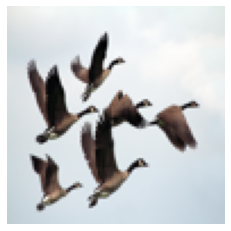

Super Resolution Image:


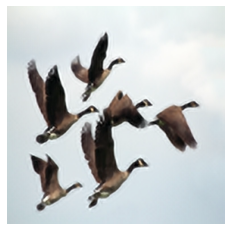

In [ ]:
test("/content/drive/MyDrive/SRCNN/TrainingData/input/95.png")